In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect
import random
import shutil

from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy import optimize
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import utils.dataset_utils as dataset
import utils.train_utils as train

In [2]:
def unit_vector_norm(X):
    X -= X.min() #remove noise offset
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [3]:
X = np.load("../data/HSI/Liver_map_150z25_60s_1TCPOBOP.npy", 'r')
Y = np.load("../data/HSI/Liver_map_150z25_60s_2TCPOBOP.npy", 'r')
Z = np.load("../data/HSI/Liver_map_150z25_60s_3OBOB.npy", 'r')
wavelength = np.load("../data/HSI/wavelength.npy", 'r')

shape_X = X.shape 
shape_Y = Y.shape 
shape_Z = Z.shape 

X = copy.copy(X.reshape(-1, X.shape[-1]))
Y = copy.copy(Y.reshape(-1, Y.shape[-1]))
Z = copy.copy(Z.reshape(-1, Z.shape[-1]))

In [4]:
class AutoEncoderConv(nn.Module):
    def __init__(self, n_components=10, h=100):
        super().__init__()
        self.encode = nn.Sequential( 
            nn.Dropout3d(0.25),
            nn.Flatten(),
            nn.Linear(1000, h),
            nn.ReLU(True),
            nn.Dropout3d(0.5),
            nn.Linear(h, n_components)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(n_components, h),
            nn.ReLU(True),
            nn.Linear(h, 1000),
            View((-1,1,1,1,1000))
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))  
        

In [5]:
def MSE_loss(x, model):
    x_ = model(x)
    return ((x - x_)**2).mean(0).sum()

In [6]:
class ReferenceVectorClassifierAE(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = {}
        self.k_means_kwargs = {}
        self.ae_kwargs = {}        
        self.set_params(**kwargs)

        _use_cuda = torch.cuda.is_available() and kwargs['cuda']
        if _use_cuda:
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True
        self.device = torch.device('cuda' if _use_cuda else 'cpu')        
        
    def fit(self, x, **kwargs):
        self.set_params(**kwargs)
        X = unit_vector_norm(x)
        
        ###################### Autoencoder ################################
        self.model = AutoEncoderConv(**self.ae_kwargs).to(self.device)
        
        parameters = filter(lambda x: x.requires_grad, self.model.parameters())
        self.optimizer = optim.Adam(parameters)        
        train_loader, test_loader = dataset.load_liver(X, self.kwargs['batch_size'])
        
        for epoch in range(self.kwargs['epochs']):
            print('-'*50)
            print('Epoch {:3d}/{:3d}'.format(epoch+1, self.kwargs['epochs']))
            start_time = datetime.now()
            train.train(self.model, self.optimizer, train_loader, self.kwargs['loss_func'], self.kwargs['log_step'], self.device)
            end_time = datetime.now()
            time_diff = relativedelta(end_time, start_time)
            print('Elapsed time: {}h {}m {}s'.format(time_diff.hours, time_diff.minutes, time_diff.seconds))
            loss = train.test(self.model, test_loader, self.kwargs['loss_func'], self.device)
            print('Validation| bits: {:2.2f}'.format(loss), flush=True)    
          
        self.model.eval()
        with torch.no_grad():
            z = self.model.encode(dataset.load_liver_all(X).to(self.device)).cpu()
              
        ###################### clustering ################################
        self.clusters = cluster.KMeans(**self.k_means_kwargs).fit(z)
        self.clusters = self.clusters.labels_
        
        one_hot = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        one_hot[range(X.shape[0]), self.clusters] = 1

        ###################### reference spectra ################################
        self.reference_spectra_ = np.array([X[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])
        self.ref_org = np.array([x[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])

        # Return the classifier
        return self

    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X = unit_vector_norm(X)
        
        ###################### RCA ################################
        old_mask = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        mask = np.ones((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        while np.abs(old_mask ^ mask).sum():
            RCA_vector = np.array([optimize.nnls(self.reference_spectra_.T * mask[i], X[i,:])[0] for i in range(X.shape[0])])
            old_mask, mask = mask, (RCA_vector.T / RCA_vector.sum(axis=1)).T >= self.kwargs['min_weight']            
        
        return RCA_vector  
    
    def get_reference_vectors(self):
        return self.reference_spectra_

    def get_org_reference_vectors(self):
        return self.ref_org    
    
    def get_params(self, deep=False):
        return self.kwargs
    
    def set_params(self, **kwargs):
        self.kwargs.update(kwargs)
        self.k_means_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(cluster.KMeans).parameters.keys())})     
        self.ae_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(AutoEncoderConv).parameters.keys())})     
        return self

In [7]:
def error_map(estimator, X, y=None):
    RCA = estimator.predict(X)
    ref_vec = estimator.get_reference_vectors()
    return ((RCA @ ref_vec - X)**2).mean(1)

def score_func(estimator, X, y=None):
    X = unit_vector_norm(X)
    return error_map(estimator, X).mean()

def print_mean_std(X):
    return f"{X.mean():<12.4e}{X.std():<12.4e}"

def cross_val_X_Y_Z(rvc, X, Y, Z):
    rvc.fit(np.concatenate((X, Y), axis=0))
    return score_func(rvc, Z)

In [8]:
kwargs = {'n_clusters': 3,
          'n_components': 5, #enough for PCA
          'min_weight': 0,
          'batch_size': 64,
          'cuda': True,
          'log_step': 10,
          'loss_func': MSE_loss,
          'epochs': 3,
          'h':100
         }
header = f"{'mean':12}{'std':12}"


In [11]:
rvc = ReferenceVectorClassifierAE(**kwargs)

repeat = 10
hs = [1000, 800, 500, 300, 100, 80, 50, 30, 10, 8, 5, 3]
error = []
for h in hs:
    print('calculating for h: ',h)
    kwargs['h'] = h
    tmp = []
    for _ in range(repeat):
        while True:
            try:
                rvc.fit(X)
                tmp.append(score_func(rvc, X))
            except ValueError:
                pass
            else: 
                break
    error.append(tmp)
error = np.array(error)

calculating for h:  1000
--------------------------------------------------
Epoch   1/  3
  2020-05-27 17:42:23|     0/   52| bits: 19.04
  2020-05-27 17:42:23|    10/   52| bits: 7.78
  2020-05-27 17:42:23|    20/   52| bits: 3.17
  2020-05-27 17:42:24|    30/   52| bits: 1.26
  2020-05-27 17:42:24|    40/   52| bits: 0.50
  2020-05-27 17:42:24|    50/   52| bits: 0.19
Elapsed time: 0h 0m 2s
Validation| bits: 0.16
--------------------------------------------------
Epoch   2/  3
  2020-05-27 17:42:31|     0/   52| bits: 0.17
  2020-05-27 17:42:32|    10/   52| bits: 0.07
  2020-05-27 17:42:32|    20/   52| bits: 0.04
  2020-05-27 17:42:32|    30/   52| bits: 0.03
  2020-05-27 17:42:32|    40/   52| bits: 0.01
  2020-05-27 17:42:32|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 17:42:37|     0/   52| bits: 0.01
  2020-05-27 17:42:37|    10/   52| bits: 0.01
  2020-05-27 17:42:37|    20/

Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 17:44:32|     0/   52| bits: 15.32
  2020-05-27 17:44:33|    10/   52| bits: 7.20
  2020-05-27 17:44:33|    20/   52| bits: 3.38
  2020-05-27 17:44:33|    30/   52| bits: 1.48
  2020-05-27 17:44:33|    40/   52| bits: 0.60
  2020-05-27 17:44:33|    50/   52| bits: 0.23
Elapsed time: 0h 0m 2s
Validation| bits: 0.19
--------------------------------------------------
Epoch   2/  3
  2020-05-27 17:44:39|     0/   52| bits: 0.19
  2020-05-27 17:44:39|    10/   52| bits: 0.07
  2020-05-27 17:44:39|    20/   52| bits: 0.03
  2020-05-27 17:44:39|    30/   52| bits: 0.02
  2020-05-27 17:44:39|    40/   52| bits: 0.01
  2020-05-27 17:44:39|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 17:44:47|     0/   52| bits: 0.01
  2020-05-27 17:44:47|    10/   52| bits: 0.01
  2020-0

  2020-05-27 17:46:31|    40/   52| bits: 0.02
  2020-05-27 17:46:31|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 17:46:38|     0/   52| bits: 21.94
  2020-05-27 17:46:38|    10/   52| bits: 9.09
  2020-05-27 17:46:38|    20/   52| bits: 3.76
  2020-05-27 17:46:38|    30/   52| bits: 1.56
  2020-05-27 17:46:38|    40/   52| bits: 0.60
  2020-05-27 17:46:38|    50/   52| bits: 0.23
Elapsed time: 0h 0m 4s
Validation| bits: 0.18
--------------------------------------------------
Epoch   2/  3
  2020-05-27 17:46:45|     0/   52| bits: 0.20
  2020-05-27 17:46:45|    10/   52| bits: 0.08
  2020-05-27 17:46:45|    20/   52| bits: 0.04
  2020-05-27 17:46:45|    30/   52| bits: 0.03
  2020-05-27 17:46:45|    40/   52| bits: 0.02
  2020-05-27 17:46:45|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-0

  2020-05-27 17:48:41|    30/   52| bits: 0.01
  2020-05-27 17:48:41|    40/   52| bits: 0.01
  2020-05-27 17:48:41|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 17:48:50|     0/   52| bits: 19.31
  2020-05-27 17:48:50|    10/   52| bits: 8.31
  2020-05-27 17:48:50|    20/   52| bits: 4.14
  2020-05-27 17:48:50|    30/   52| bits: 2.01
  2020-05-27 17:48:50|    40/   52| bits: 0.96
  2020-05-27 17:48:50|    50/   52| bits: 0.43
Elapsed time: 0h 0m 4s
Validation| bits: 0.31
--------------------------------------------------
Epoch   2/  3
  2020-05-27 17:48:56|     0/   52| bits: 0.36
  2020-05-27 17:48:56|    10/   52| bits: 0.17
  2020-05-27 17:48:56|    20/   52| bits: 0.08
  2020-05-27 17:48:56|    30/   52| bits: 0.04
  2020-05-27 17:48:56|    40/   52| bits: 0.02
  2020-05-27 17:48:56|    50/   52| bits: 0.02
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------

  2020-05-27 17:50:52|    20/   52| bits: 0.01
  2020-05-27 17:50:52|    30/   52| bits: 0.01
  2020-05-27 17:50:52|    40/   52| bits: 0.01
  2020-05-27 17:50:52|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 17:50:56|     0/   52| bits: 19.04
  2020-05-27 17:50:57|    10/   52| bits: 8.35
  2020-05-27 17:50:57|    20/   52| bits: 3.61
  2020-05-27 17:50:57|    30/   52| bits: 1.52
  2020-05-27 17:50:57|    40/   52| bits: 0.63
  2020-05-27 17:50:57|    50/   52| bits: 0.25
Elapsed time: 0h 0m 2s
Validation| bits: 0.21
--------------------------------------------------
Epoch   2/  3
  2020-05-27 17:51:03|     0/   52| bits: 0.21
  2020-05-27 17:51:03|    10/   52| bits: 0.09
  2020-05-27 17:51:03|    20/   52| bits: 0.04
  2020-05-27 17:51:04|    30/   52| bits: 0.02
  2020-05-27 17:51:04|    40/   52| bits: 0.01
  2020-05-27 17:51:04|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Va

  2020-05-27 17:52:52|    10/   52| bits: 0.01
  2020-05-27 17:52:52|    20/   52| bits: 0.01
  2020-05-27 17:52:52|    30/   52| bits: 0.01
  2020-05-27 17:52:52|    40/   52| bits: 0.01
  2020-05-27 17:52:52|    50/   52| bits: 0.01
Elapsed time: 0h 0m 3s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 17:52:59|     0/   52| bits: 23.99
  2020-05-27 17:52:59|    10/   52| bits: 9.40
  2020-05-27 17:53:00|    20/   52| bits: 3.72
  2020-05-27 17:53:00|    30/   52| bits: 1.50
  2020-05-27 17:53:00|    40/   52| bits: 0.59
  2020-05-27 17:53:00|    50/   52| bits: 0.24
Elapsed time: 0h 0m 2s
Validation| bits: 0.18
--------------------------------------------------
Epoch   2/  3
  2020-05-27 17:53:03|     0/   52| bits: 0.20
  2020-05-27 17:53:04|    10/   52| bits: 0.08
  2020-05-27 17:53:04|    20/   52| bits: 0.04
  2020-05-27 17:53:04|    30/   52| bits: 0.02
  2020-05-27 17:53:04|    40/   52| bits: 0.02
  2020-05-27 17:53:04|   

  2020-05-27 17:55:02|     0/   52| bits: 0.01
  2020-05-27 17:55:03|    10/   52| bits: 0.01
  2020-05-27 17:55:03|    20/   52| bits: 0.01
  2020-05-27 17:55:03|    30/   52| bits: 0.01
  2020-05-27 17:55:03|    40/   52| bits: 0.01
  2020-05-27 17:55:03|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 17:55:10|     0/   52| bits: 18.20
  2020-05-27 17:55:10|    10/   52| bits: 8.15
  2020-05-27 17:55:11|    20/   52| bits: 4.04
  2020-05-27 17:55:11|    30/   52| bits: 2.07
  2020-05-27 17:55:11|    40/   52| bits: 1.02
  2020-05-27 17:55:11|    50/   52| bits: 0.49
Elapsed time: 0h 0m 2s
Validation| bits: 0.39
--------------------------------------------------
Epoch   2/  3
  2020-05-27 17:55:15|     0/   52| bits: 0.43
  2020-05-27 17:55:15|    10/   52| bits: 0.21
  2020-05-27 17:55:15|    20/   52| bits: 0.11
  2020-05-27 17:55:15|    30/   52| bits: 0.06
  2020-05-27 17:55:15|   

--------------------------------------------------
Epoch   3/  3
  2020-05-27 17:57:12|     0/   52| bits: 0.01
  2020-05-27 17:57:12|    10/   52| bits: 0.01
  2020-05-27 17:57:12|    20/   52| bits: 0.01
  2020-05-27 17:57:12|    30/   52| bits: 0.01
  2020-05-27 17:57:12|    40/   52| bits: 0.01
  2020-05-27 17:57:12|    50/   52| bits: 0.01
Elapsed time: 0h 0m 3s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 17:57:21|     0/   52| bits: 17.46
  2020-05-27 17:57:21|    10/   52| bits: 7.46
  2020-05-27 17:57:21|    20/   52| bits: 3.00
  2020-05-27 17:57:21|    30/   52| bits: 1.16
  2020-05-27 17:57:21|    40/   52| bits: 0.44
  2020-05-27 17:57:21|    50/   52| bits: 0.16
Elapsed time: 0h 0m 4s
Validation| bits: 0.13
--------------------------------------------------
Epoch   2/  3
  2020-05-27 17:57:26|     0/   52| bits: 0.13
  2020-05-27 17:57:26|    10/   52| bits: 0.05
  2020-05-27 17:57:26|    20/   52| bits: 0.03
  2020-

Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 17:59:21|     0/   52| bits: 0.01
  2020-05-27 17:59:21|    10/   52| bits: 0.01
  2020-05-27 17:59:21|    20/   52| bits: 0.01
  2020-05-27 17:59:21|    30/   52| bits: 0.01
  2020-05-27 17:59:21|    40/   52| bits: 0.01
  2020-05-27 17:59:21|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 17:59:27|     0/   52| bits: 19.47
  2020-05-27 17:59:27|    10/   52| bits: 7.80
  2020-05-27 17:59:27|    20/   52| bits: 3.38
  2020-05-27 17:59:27|    30/   52| bits: 1.38
  2020-05-27 17:59:27|    40/   52| bits: 0.52
  2020-05-27 17:59:27|    50/   52| bits: 0.21
Elapsed time: 0h 0m 3s
Validation| bits: 0.16
--------------------------------------------------
Epoch   2/  3
  2020-05-27 17:59:36|     0/   52| bits: 0.17
  2020-05-27 17:59:37|    10/   52| bits: 0.07
  2020-0

  2020-05-27 18:02:46|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 18:02:58|     0/   52| bits: 0.01
  2020-05-27 18:02:58|    10/   52| bits: 0.01
  2020-05-27 18:02:58|    20/   52| bits: 0.01
  2020-05-27 18:02:58|    30/   52| bits: 0.01
  2020-05-27 18:02:58|    40/   52| bits: 0.01
  2020-05-27 18:02:58|    50/   52| bits: 0.01
Elapsed time: 0h 0m 6s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 18:03:05|     0/   52| bits: 21.65
  2020-05-27 18:03:06|    10/   52| bits: 8.05
  2020-05-27 18:03:06|    20/   52| bits: 3.06
  2020-05-27 18:03:06|    30/   52| bits: 1.17
  2020-05-27 18:03:06|    40/   52| bits: 0.45
  2020-05-27 18:03:06|    50/   52| bits: 0.17
Elapsed time: 0h 0m 3s
Validation| bits: 0.13
--------------------------------------------------
Epoch   2/  3
  2020-05-27 18:03:13|     0/   52| bits: 0.14
  2020-0

  2020-05-27 18:06:25|    40/   52| bits: 0.01
  2020-05-27 18:06:25|    50/   52| bits: 0.01
Elapsed time: 0h 0m 5s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 18:06:32|     0/   52| bits: 0.01
  2020-05-27 18:06:32|    10/   52| bits: 0.01
  2020-05-27 18:06:32|    20/   52| bits: 0.01
  2020-05-27 18:06:32|    30/   52| bits: 0.01
  2020-05-27 18:06:32|    40/   52| bits: 0.01
  2020-05-27 18:06:32|    50/   52| bits: 0.01
Elapsed time: 0h 0m 3s
Validation| bits: 0.01
calculating for h:  30
--------------------------------------------------
Epoch   1/  3
  2020-05-27 18:06:43|     0/   52| bits: 15.33
  2020-05-27 18:06:44|    10/   52| bits: 6.30
  2020-05-27 18:06:44|    20/   52| bits: 2.49
  2020-05-27 18:06:44|    30/   52| bits: 0.93
  2020-05-27 18:06:44|    40/   52| bits: 0.34
  2020-05-27 18:06:44|    50/   52| bits: 0.14
Elapsed time: 0h 0m 6s
Validation| bits: 0.11
--------------------------------------------------

  2020-05-27 18:09:08|    30/   52| bits: 0.03
  2020-05-27 18:09:08|    40/   52| bits: 0.02
  2020-05-27 18:09:08|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 18:09:14|     0/   52| bits: 0.01
  2020-05-27 18:09:15|    10/   52| bits: 0.01
  2020-05-27 18:09:15|    20/   52| bits: 0.01
  2020-05-27 18:09:15|    30/   52| bits: 0.01
  2020-05-27 18:09:15|    40/   52| bits: 0.01
  2020-05-27 18:09:15|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 18:09:23|     0/   52| bits: 26.81
  2020-05-27 18:09:23|    10/   52| bits: 10.02
  2020-05-27 18:09:23|    20/   52| bits: 3.80
  2020-05-27 18:09:23|    30/   52| bits: 1.43
  2020-05-27 18:09:23|    40/   52| bits: 0.55
  2020-05-27 18:09:23|    50/   52| bits: 0.21
Elapsed time: 0h 0m 2s
Validation| bits: 0.15
-------------------------

  2020-05-27 18:11:21|    20/   52| bits: 0.04
  2020-05-27 18:11:21|    30/   52| bits: 0.02
  2020-05-27 18:11:21|    40/   52| bits: 0.01
  2020-05-27 18:11:21|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 18:11:27|     0/   52| bits: 0.01
  2020-05-27 18:11:27|    10/   52| bits: 0.01
  2020-05-27 18:11:27|    20/   52| bits: 0.01
  2020-05-27 18:11:28|    30/   52| bits: 0.01
  2020-05-27 18:11:28|    40/   52| bits: 0.01
  2020-05-27 18:11:28|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 18:11:36|     0/   52| bits: 26.64
  2020-05-27 18:11:36|    10/   52| bits: 8.69
  2020-05-27 18:11:36|    20/   52| bits: 3.53
  2020-05-27 18:11:36|    30/   52| bits: 1.44
  2020-05-27 18:11:36|    40/   52| bits: 0.58
  2020-05-27 18:11:36|    50/   52| bits: 0.22
Elapsed time: 0h 0m 3s
Va

  2020-05-27 18:13:32|    10/   52| bits: 0.06
  2020-05-27 18:13:32|    20/   52| bits: 0.03
  2020-05-27 18:13:32|    30/   52| bits: 0.02
  2020-05-27 18:13:32|    40/   52| bits: 0.01
  2020-05-27 18:13:32|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 18:13:38|     0/   52| bits: 0.01
  2020-05-27 18:13:38|    10/   52| bits: 0.01
  2020-05-27 18:13:38|    20/   52| bits: 0.01
  2020-05-27 18:13:38|    30/   52| bits: 0.01
  2020-05-27 18:13:38|    40/   52| bits: 0.01
  2020-05-27 18:13:38|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 18:13:42|     0/   52| bits: 13.92
  2020-05-27 18:13:42|    10/   52| bits: 6.97
  2020-05-27 18:13:42|    20/   52| bits: 3.32
  2020-05-27 18:13:42|    30/   52| bits: 1.51
  2020-05-27 18:13:42|    40/   52| bits: 0.66
  2020-05-27 18:13:43|   

  2020-05-27 18:15:40|     0/   52| bits: 0.22
  2020-05-27 18:15:40|    10/   52| bits: 0.09
  2020-05-27 18:15:40|    20/   52| bits: 0.04
  2020-05-27 18:15:40|    30/   52| bits: 0.02
  2020-05-27 18:15:40|    40/   52| bits: 0.02
  2020-05-27 18:15:40|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 18:15:47|     0/   52| bits: 0.01
  2020-05-27 18:15:47|    10/   52| bits: 0.01
  2020-05-27 18:15:47|    20/   52| bits: 0.01
  2020-05-27 18:15:47|    30/   52| bits: 0.01
  2020-05-27 18:15:47|    40/   52| bits: 0.01
  2020-05-27 18:15:47|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 18:15:55|     0/   52| bits: 18.07
  2020-05-27 18:15:55|    10/   52| bits: 7.24
  2020-05-27 18:15:55|    20/   52| bits: 2.76
  2020-05-27 18:15:55|    30/   52| bits: 1.03
  2020-05-27 18:15:55|   

Validation| bits: 0.24
--------------------------------------------------
Epoch   2/  3
  2020-05-27 18:17:45|     0/   52| bits: 0.26
  2020-05-27 18:17:45|    10/   52| bits: 0.11
  2020-05-27 18:17:45|    20/   52| bits: 0.05
  2020-05-27 18:17:45|    30/   52| bits: 0.03
  2020-05-27 18:17:45|    40/   52| bits: 0.02
  2020-05-27 18:17:45|    50/   52| bits: 0.02
Elapsed time: 0h 0m 3s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 18:17:52|     0/   52| bits: 0.01
  2020-05-27 18:17:53|    10/   52| bits: 0.01
  2020-05-27 18:17:53|    20/   52| bits: 0.01
  2020-05-27 18:17:53|    30/   52| bits: 0.01
  2020-05-27 18:17:53|    40/   52| bits: 0.01
  2020-05-27 18:17:53|    50/   52| bits: 0.01
Elapsed time: 0h 0m 4s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-27 18:17:58|     0/   52| bits: 21.07
  2020-05-27 18:17:58|    10/   52| bits: 8.59
  2020-05-27 18:17:58|    20/  

  2020-05-27 18:19:52|    40/   52| bits: 0.63
  2020-05-27 18:19:52|    50/   52| bits: 0.27
Elapsed time: 0h 0m 2s
Validation| bits: 0.19
--------------------------------------------------
Epoch   2/  3
  2020-05-27 18:19:56|     0/   52| bits: 0.22
  2020-05-27 18:19:56|    10/   52| bits: 0.10
  2020-05-27 18:19:56|    20/   52| bits: 0.05
  2020-05-27 18:19:56|    30/   52| bits: 0.02
  2020-05-27 18:19:57|    40/   52| bits: 0.02
  2020-05-27 18:19:57|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 18:20:02|     0/   52| bits: 0.01
  2020-05-27 18:20:02|    10/   52| bits: 0.01
  2020-05-27 18:20:03|    20/   52| bits: 0.01
  2020-05-27 18:20:03|    30/   52| bits: 0.01
  2020-05-27 18:20:03|    40/   52| bits: 0.01
  2020-05-27 18:20:03|    50/   52| bits: 0.01
Elapsed time: 0h 0m 3s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05

  2020-05-27 18:21:51|    30/   52| bits: 1.12
  2020-05-27 18:21:51|    40/   52| bits: 0.42
  2020-05-27 18:21:51|    50/   52| bits: 0.16
Elapsed time: 0h 0m 2s
Validation| bits: 0.13
--------------------------------------------------
Epoch   2/  3
  2020-05-27 18:21:55|     0/   52| bits: 0.13
  2020-05-27 18:21:55|    10/   52| bits: 0.05
  2020-05-27 18:21:55|    20/   52| bits: 0.03
  2020-05-27 18:21:55|    30/   52| bits: 0.01
  2020-05-27 18:21:55|    40/   52| bits: 0.01
  2020-05-27 18:21:55|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   3/  3
  2020-05-27 18:22:00|     0/   52| bits: 0.01
  2020-05-27 18:22:00|    10/   52| bits: 0.01
  2020-05-27 18:22:00|    20/   52| bits: 0.01
  2020-05-27 18:22:00|    30/   52| bits: 0.01
  2020-05-27 18:22:00|    40/   52| bits: 0.01
  2020-05-27 18:22:00|    50/   52| bits: 0.01
Elapsed time: 0h 0m 3s
Validation| bits: 0.01
---------------------------

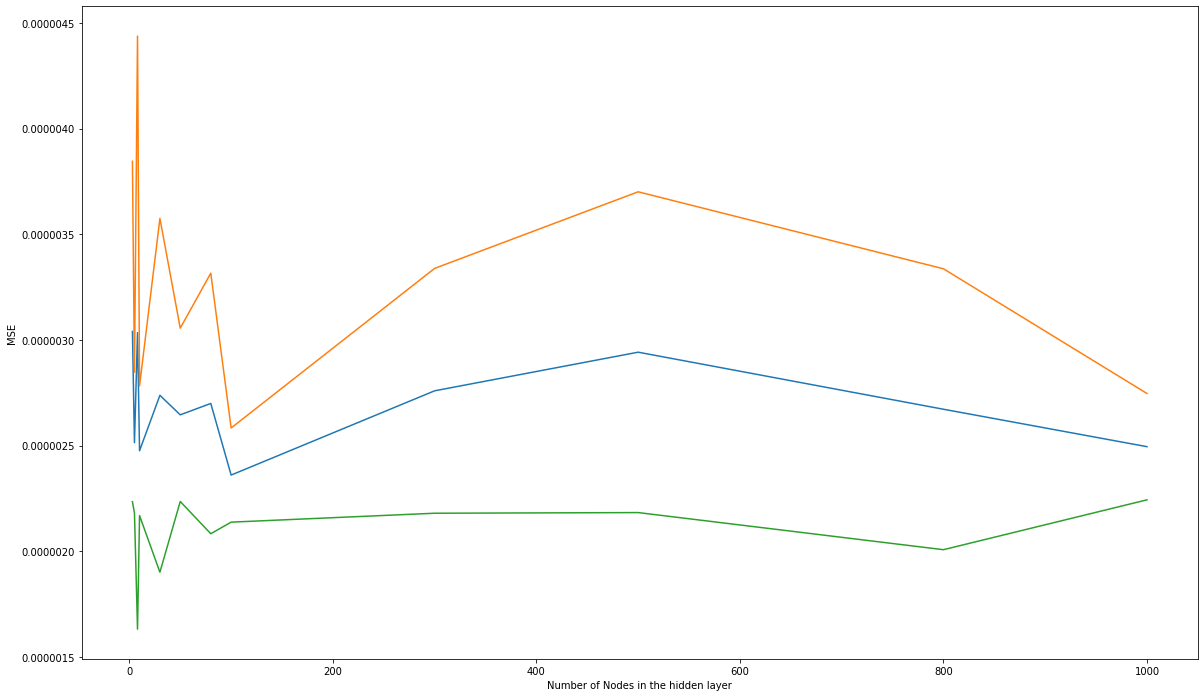

In [12]:
plt.figure(figsize = (20,12))
plt.plot(hs, error.mean(1))
plt.plot(hs, error.mean(1) + error.std(1))
plt.plot(hs, error.mean(1) - error.std(1))
plt.ylabel('MSE')
plt.xlabel('Number of Nodes in the hidden layer')
plt.show()